# Back / Foreground separation
In this notebook we try to detect background pixels and remove them from image in order to keep only objets with different colour that, in our case, would be the panel we must operate on.\
We tested here the main idea, tuned the parameter for an optimal output, and then we will extend that to real scenario.\
This code is organized as follow:

**input:** single frame extracted from video stream

**output:** image of panel(ROI) with few other elements, polarized background
1. **decide when there is no panel in sight**: histogram distribution
2. **sample image to extract background color**: use mean/camshift to reach a particularly populated area wrt certaint distribution of pixels
3. **extract background pixel from the image**: backprojection
4. **result improvement**

((https://stackoverflow.com/questions/44825180/rectangle-document-detection-using-hough-transform-opencv-android))

https://docs.opencv.org/master/d7/d7b/classcv_1_1BackgroundSubtractorMOG2.html

https://docs.opencv.org/master/de/df4/tutorial_js_bg_subtraction.html

https://docs.opencv.org/master/d1/dc5/tutorial_background_subtraction.html

https://stackoverflow.com/questions/22133178/moving-background-subtraction-opencv

using background subtraction library, calculating background as the mean of various images (i.e. extracted frames from a video of the surraounding

In [126]:
# INCLUDE
####
# IMAGE STREAM ACQUISITION
#    video stream management?(elsewhere)
#.    first/usefull frames memorization
#    video stream (general) filtering
#
####
# IMAGE FILTERING/CONVERSION FOR COLOR ENHANCEMENT
#..    hsv space used (least inlfuence from environmental changes)
#    filtering for lowering noise/luminosity peaks
#    color clustering on histogram?
#    colored rocks recognition?
#
####
# SOURCE HISTOGRAMS
####
# hist params
####
#..    computatation
#..    normalization
#
####
# ROIs DEFINITION AND HISTOGRAMS
####
# CFD comparing methods and parameters
####
#    roi identification: 
#..       - samples library
#       - extraction from stream source:
#..           1) hardcoded dimension/ proportion of source's dimension
#.           2) rnd points/size
#           3) adaptive wrt source's features
#.           4) manual (human)
## watershed/clustering for regions segmentation
#
####
# ADAPTIVE MASK
####
# parameters
## moved inside roi definition method because are dipending by that
## may be adaptable from roi dimension
#    roi hist filtering?
#.    roi histogram correllation testing:
#..        1) pass/non pass test to eliminate low correlated samples
#        2) mask weight proportional to correlation
#..    backprojection mask
#..    structuring element for planar filtering
#..    back/foreground separation
#
####
# MASK IMPROVEMENT
#    biggest contiguous region (as it could be the panel)
#    foreground filtering?
#    mini blobs remotion, especially in less/most transformed areas
#
##moved to next step



In [4]:
def bgVStream(srcBgVS):#add source device ofsource of video stream
    return cv.imread(srcBgVS)

In [10]:
def bgPreFilt(srcBgPF,paramBgPF=cv.COLOR_BGR2HSV):
    return cv.cvtColor(srcBgPF,paramBgPF)

In [ ]:
def bgForeMask(image2mask,roiLibrary,maskParam=0):

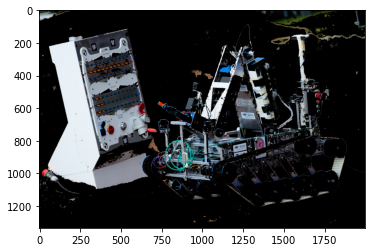

In [30]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob


###
# stream acquisition function, by path/address
def bgVStream(srcBgVS):
    return cv.imread(srcBgVS)

# prefiltering function
def bgPreFilt(srcBgPF,paramBgPF=cv.COLOR_BGR2HSV):
    return cv.cvtColor(srcBgPF,paramBgPF)
# post filtering function
def bgForeImprov(srcFI,paramgbFI=0):
    return srcFI
# histogram param, for hs(v) space
h_bins = 180
s_bins = 256
histSize = [h_bins, s_bins]
h_ranges = [0, 180]
s_ranges = [0, 256]
ranges = h_ranges + s_ranges
channels = [0, 1]

# histogram(cdf) comparison method
histCompLib = (
    ("Correlation", cv.HISTCMP_CORREL),
    ("Chi-Squared", cv.HISTCMP_CHISQR),
    ("Intersection", cv.HISTCMP_INTERSECT),
    ("Hellinger", cv.HISTCMP_BHATTACHARYYA),
    ("Kullback-Leibler",cv.HISTCMP_KL_DIV))

# choosen method
_,histCompMet=histCompLib[0]

# histogram comparison threshold
#compTresRoi: CORREL:0.4,CHISQR:10000000,INTERSECT:0.45,BHATTACHARYYA:?,KULLBACK:500
compTresRoi=10000000 if histCompMet==cv.HISTCMP_CHISQR else 0.3

############################
# samples folder
sampLibPath='../../images/marsyard/samples/terrain/'
# roi extraction methods   
roiMet=('library',
        'stream')
# selected roi extraction method
srcMetROi=roiMet[0]
##############################
# mask's filter param and threshold value (mask is decimal)
if srcMetROi=='library':      
    sizeEl=3
    elemType=cv.MORPH_RECT
    threshval=10#CORREL:10, CHISQR:0-20,
    
elif srcMetROi=='stream':
    elemNumber=4
    dimRowRoi=img.shape[0]//elemNumber
    dimColRoi=img.shape[1]//elemNumber
        
    sizeEl=4
    elemType=cv.MORPH_RECT
    threshval=50    
################################
# source definition
srcImgLib='../../images/marsyard/'

## may use multiple sources
srcImgPath=srcImgLib+'task.jpg'
if 1:## just to keep indentation
#for srcImgPath in glob.glob(srcImgLib+"*.jpg"):
    # source acquisition
    img=bgVStream(srcImgPath)
    foreground=img.copy()
    # source prefiltering
    imgh=bgPreFilt(img)
    # source histogram
    imghhist = cv.calcHist([imgh], channels, None, histSize, ranges, accumulate=False)
    cv.normalize(imghhist, imghhist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

    usefullRoi=[]
#################################################################
    # picks roi from samples library
    if srcMetROi=='library':
        for tempLibImg in glob.glob(sampLibPath+"*.jpg"):## manages only .jpg
            # roi acquisition
            currentRoi=cv.cvtColor(cv.imread(tempLibImg),cv.COLOR_BGR2HSV)
            # roi hist
            roihhist= cv.calcHist([currentRoi], channels, None, histSize, ranges, accumulate=False)
            cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
            # roi correlation test
            if cv.compareHist(imghhist, roihhist, histCompMet)>compTresRoi:
                # usefull roi saved
                usefullRoi.append(currentRoi)
                # roi mask, mask smoothing and binarization, 3 channels mask
                bpMask = cv.calcBackProject([imgh],channels,roihhist,ranges,1)
                cv.filter2D(bpMask,-1,cv.getStructuringElement(elemType,(sizeEl,sizeEl)),bpMask)
                _,thresh = cv.threshold(bpMask,threshval,255,0)
                thresh = cv.merge((thresh,thresh,thresh))
                # background subtraction
                foreground = cv.bitwise_and(foreground,cv.bitwise_not(thresh))
    
    # picks roi from target image itself
    elif srcMetROi=='stream':
        # target grid division
        for jj in range(0,img.shape[0],dimRowRoi):
            for ii in range(0,img.shape[1],dimColRoi):
                # roi acquisition
                currentRoi=cv.cvtColor(img[jj:jj+dimRowRoi,ii:ii+dimColRoi],cv.COLOR_BGR2HSV)
                # roi histogram
                roihhist= cv.calcHist([currentRoi], channels, None, histSize, ranges, accumulate=False)
                cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
                # roi correlation test
                if cv.compareHist(imghhist, roihhist, histCompMet)>compTresRoi:
                    # usefull roi saved
                    usefullRoi.append(currentRoi)
                    # roi mask, mask smoothing and binarization, 3 channels mask
                    bpMask = cv.calcBackProject([imgh],channels,roihhist,ranges,1)
                    cv.filter2D(bpMask,-1,cv.getStructuringElement(elemType,(sizeEl,sizeEl)),bpMask)
                    _,thresh = cv.threshold(bpMask,threshval,255,0)
                    thresh = cv.merge((thresh,thresh,thresh))
                    # background subtraction
                    foreground = cv.bitwise_and(foreground,cv.bitwise_not(thresh))

#plt.figure(figsize=(20,10))
# foreground, with removed background
plt.imshow(cv.cvtColor(foreground,cv.COLOR_BGR2RGB))
plt.show()
#backGround=img-foreGround
# foreground as if robot wasn't


## ADDENDUM

### on image prefiltering

### on roi acquisition

to reduce computation load, sample could be tested to avoid too much similarity with the previous one, harming the mean value (this part is deprecated since histogram stacking is no longer considered)

histogram stacking and averaging doesn't seem a good method, since more mask are simpler

final code should include samples from library, automatic and manual selection from stream;

automatic selection: regular grid on image and testing on correlation between them; random points and accretion of areas, with test on correlation; dimension/number of rois adaptivity wrt source features( biggest contours, watershed results, largest contiguous similar regions)

### on histograms and correlation test

V channel excluded because it's heavily influenced by light/environment conditions

V channel ranges, bins, max value could be toggles

still H,S channel are device dependent, LAB space in indipendent

in opencv H €[0,179], while S,V €[0,255]

### on mask and parameters



In [ ]:
# code to add for others roi selection methods 
    
    #    elif extrMetStream=='random':
 #       roih=50
  #      roiw=50
   #     for (centerx,centery) in centers:
    #        #centerx,centery=func2extractcenter(image)
     #       roimg=image[centery-roih//2:centery+roih//2,centerx-roiw//2:centerx+roiw//2]
      #      roi.append(cv.cvtColor(roimg, cv.COLOR_BGR2HSV))
       #     interpolation=np.median
        #    roistack=np.stack(roi,axis=0)
         #   roimean=interpolation(roistack,axis=0)
    #elif extrMetStream=='manual':

# FOREGROUND MASK IMPROVING



In [2]:
####
# MASK IMPROVEMENT
#    biggest contiguous region (as it could be the panel)
#    foreground filtering?
#    mini blobs remotion, especially in less/most transformed areas
#



####
# FOREGROUND TRACKING AND MASK ITERACTION
#    foreground histogram
#    foreground backprojection mask
#    foreground tracking with camshift
#    iterated foreground mask by tracking
#    total mask by summing back/foreground ones
#    new foreground identification and iteraction
## minAreaRect(maxContour) to identificate panel after masking


In [1]:
def bgForeImprov(srcFI,paramgbFI=6):
    #return srcFI
    kernel=cv.getStructuringElement(cv.MORPH_RECT,(paramgbFI,paramgbFI))
    morphed=cv.morphologyEx(srcFI,cv.MORPH_CLOSE,kernel)
    return cv.morphologyEx(morphed,cv.MORPH_RECT,kernel)

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
  
##result of previous code coventiently modified as if robot not present
foreground=cv.imread('../../images/panel/extpaneltask_real.jpg')
foreground=bgForeImprov(foreground)


**issues:** biggest contour open even after dilation operation (and various other ones); hence, the smallest region completely encapsulatin it is the convex hull, which includes also blobs/pixels from outside the panel and **a lot of black pixels**, which harm the camshift (since mask creates a black background)

try to exclude black pixels from histogram

### further mask refinement

part which removed everything outside [hull of] max area/length contour found, has been moved to foreground tracking and motion control, since that code is needed to extract the roi; this will avoid redundancy once code will the joined together